In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
from pandas.plotting import scatter_matrix
import scipy.stats as stats
import seaborn as sns
from nltk.util import ngrams
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import  SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import datasets, linear_model, pipeline, feature_extraction, ensemble, neighbors, tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, balanced_accuracy_score
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
import string
import sys
import warnings
warnings.filterwarnings("ignore")
import pprint

In [2]:
from src.item_recommender import ItemRecommender

In [3]:
# importing the data
initial_data = pd.read_csv('data/winemag-data-130k-v2.csv')

In [4]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [5]:
initial_data.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimstone and dried herb. The palate isn't overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity.",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth while still structured. Firm tannins are filled out with juicy red berry fruits and freshened with acidity. It's already drinkable, although it will certainly be better from 2016.",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and rind dominate. Some green pineapple pokes through, with crisp acidity underscoring the flavors. The wine was all stainless-steel fermented.",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom start off the aromas. The palate is a bit more opulent, with notes of honey-drizzled guava and mango giving way to a slightly astringent, semidry finish.",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling (Lake Michigan Shore),Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this comes across as rather rough and tannic, with rustic, earthy, herbal characteristics. Nonetheless, if you think of it as a pleasantly unfussy country wine, it's a good companion to a hearty winter stew.",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child Block Pinot Noir (Willamette Valley),Pinot Noir,Sweet Cheeks


In [6]:
# dropping column information I do not need or want to use
new_df = initial_data.drop(['region_1', 'region_2', 'designation', 'province', 'taster_twitter_handle'], axis=1)

In [7]:
new_df['winery_variety'] = new_df['winery'] +' ' + new_df['variety']

In [8]:
new_df.head()

,Unnamed: 0,country,description,points,price,taster_name,title,variety,winery,winery_variety
0,0,Italy,"Aromas include tropical fruit, broom, brimstone and dried herb. The palate isn't overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity.",87,NaN,Kerin O’Keefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,Nicosia White Blend
1,1,Portugal,"This is ripe and fruity, a wine that is smooth while still structured. Firm tannins are filled out with juicy red berry fruits and freshened with acidity. It's already drinkable, although it will certainly be better from 2016.",87,15.0,Roger Voss,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,Quinta dos Avidagos Portuguese Red
2,2,US,"Tart and snappy, the flavors of lime flesh and rind dominate. Some green pineapple pokes through, with crisp acidity underscoring the flavors. The wine was all stainless-steel fermented.",87,14.0,Paul Gregutt,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,Rainstorm Pinot Gris
3,3,US,"Pineapple rind, lemon pith and orange blossom start off the aromas. The palate is a bit more opulent, with notes of honey-drizzled guava and mango giving way to a slightly astringent, semidry finish.",87,13.0,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling (Lake Michigan Shore),Riesling,St. Julian,St. Julian Riesling
4,4,US,"Much like the regular bottling from 2012, this comes across as rather rough and tannic, with rustic, earthy, herbal characteristics. Nonetheless, if you think of it as a pleasantly unfussy country wine, it's a good companion to a hearty winter stew.",87,65.0,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child Block Pinot Noir (Willamette Valley),Pinot Noir,Sweet Cheeks,Sweet Cheeks Pinot Noir


In [9]:
new_df.isna().sum()

Unnamed: 0            0
country              63
description           0
points                0
price              8996
taster_name       26244
title                 0
variety               1
winery                0
winery_variety        1
dtype: int64

In [10]:
new_df = new_df.drop_duplicates('description', keep='first')

In [11]:
new_df.shape

(119955, 10)

In [12]:
new_df.isna().sum()

Unnamed: 0            0
country              59
description           0
points                0
price              8388
taster_name       24912
title                 0
variety               1
winery                0
winery_variety        1
dtype: int64

In [13]:
new_df.dropna(axis=0, inplace=True)
new_df.shape

(88244, 10)

In [14]:
new_df.isna().sum()

Unnamed: 0        0
country           0
description       0
points            0
price             0
taster_name       0
title             0
variety           0
winery            0
winery_variety    0
dtype: int64

In [15]:
country_count = new_df['country'].value_counts()

country_count

US                        34261
France                    16041
Italy                      9117
Spain                      5985
Portugal                   4497
Chile                      4019
Argentina                  3498
Austria                    2527
Germany                    1924
Australia                  1887
New Zealand                1143
South Africa               1123
Israel                      448
Greece                      426
Canada                      223
Bulgaria                    132
Hungary                     127
Romania                     102
Uruguay                      98
Turkey                       81
Georgia                      74
Slovenia                     70
Croatia                      68
Mexico                       63
England                      59
Moldova                      56
Brazil                       44
Lebanon                      32
Morocco                      24
Peru                         16
Ukraine                      14
Macedoni

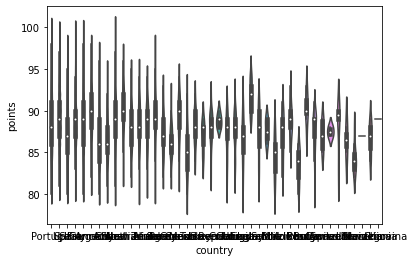

In [16]:
ax = sns.violinplot(x='country', y='points' ,data=new_df)

In [17]:
# country_count = new_df['country'].value_counts()
# country_count = country_count[:15,]
# # groups = new_df.groupby('country').filter(lambda x: len(x) >= 200).reset_index()
# plt.figure(figsize=(15,8))
# sns.boxplot(x=new_df['country'], y=new_df['points'].mean())
# plt.title('How Countries Rated Wine')
# plt.ylabel('Wine Ratings', fontsize=16)
# plt.xlabel('Country', fontsize=16)
# plt.show()

# TF IDF Recommendation

In [18]:
# Custom list of stop words

extras = ['red', 'white', 'Cabernet Sauvignon', 'Sauvignon Blanc', 'Pinot Noir',
       'Chardonnay', 'Tempranillo', 'Malbec', 'Syrah', 'Sangiovese',
       'Riesling', 'Nebbiolo', 'Pinot Gris', 'Glera', 'Viognier',
       'Pinot Grigio', 'Cabernet Franc', 'Zinfandel', 'Barbera',
       'Albariño', 'Bordeaux-style Red Blend', 'Gewürztraminer', 'Merlot',
       'Grüner Veltliner', 'Pinot Blanc', 'Shiraz', 'Chenin Blanc', 'merlot', 'pinot', 'chardonnay','noir','cabernet','sauvignon', 'bordeaux','riesling','syrah','viognier', 'wine', 'flavors', 'fruit', 'palate','finish','aromas','notes','drink','years','good','like','nose','ripe','acidity',]
stop = set(stopwords.words('english'))
stop.update(extras)

In [25]:
sample = new_df.sample(50000).reset_index(drop=True)
sample.head(125)

,Unnamed: 0,country,description,points,price,taster_name,title,variety,winery,winery_variety
0,128339,US,"Clean and fresh, this pure varietal Grenache captures the fruit nicely. Aged in neutral French oak for 15 months, it has smoothed out but shows no barrel spice at all. It's fruit, acid and crisp tannins, all in good proportion.",88,25.0,Paul Gregutt,Tertulia 2008 Lonesome Spring Ranch Grenache (Yakima Valley),Grenache,Tertulia,Tertulia Grenache
1,47960,US,"Just a single barrel was made, pure Sangiovese from the Candy Mountain Vineyard. Tight, tart and dark, it captures black cherry fruit with black licorice and a whiff of smoke. At this point in time the tannins and acids seem to be fighting it out for control.",88,50.0,Paul Gregutt,Boudreaux Cellars 2006 Sangiovese (Columbia Valley (WA)),Sangiovese,Boudreaux Cellars,Boudreaux Cellars Sangiovese
2,32863,Argentina,"For several vintages running Broquel has nudged the border between very good and excellent, but as in years past the '06 is a touch tangy and racy, with black cherry, plum and berry flavors. It's bold, zippy and quite high-toned, but still it's very competent and held together.",89,17.0,Michael Schachner,Trapiche 2006 Broquel Malbec (Mendoza),Malbec,Trapiche,Trapiche Malbec
3,92481,US,"Each of Channing Daughter's eight 2011 vintage rosato express a distinct personality, but the Mudd Vineyard Merlot stands out with its seamless integration of ripe, supple fruit with intense minerality and a dewy, floral flair that's irresistible, sip after sip. This is bone dry and begs to be opened as soon as possible.",90,18.0,Anna Lee C. Iijima,Channing Daughters 2011 Rosato Merlot Mudd Vineyard Rosé (North Fork of Long Island),Rosé,Channing Daughters,Channing Daughters Rosé
4,11066,Italy,"Fragrant blue flower, black plum, eucalyptus and a whiff of exotic spice lead the nose. The firm palate offers dried black cherry, pomegranate, vanilla and mocha alongside austere, fine-grained tannins that give the finish grip.",89,35.0,Kerin O’Keefe,Principe Corsini 2013 Cortevecchia Riserva (Chianti Classico),Red Blend,Principe Corsini,Principe Corsini Red Blend
5,116619,Germany,"Exotic spice, stone fruit and orange rind tones perfume this aromatic dry Riesling. Full bodied and lusciously textured, it gains a cutting, linear feel on the midpalate from staccato strikes of lime pith and lemony acidity. It's a finely poised wine with dramatic complexity that's likely to evolve well through 2025.",92,54.0,Anna Lee C. Iijima,Domdechant Werner 2013 Hochheimer Kirchenstück Trocken GG Erste Lage Riesling (Rheingau),Riesling,Domdechant Werner,Domdechant Werner Riesling
6,20573,US,"Soft and diffuse, this offers light flavors of pear with a hint of spice. Done entirely in stainless steel, it's a good, all-purpose white.",86,14.0,Paul Gregutt,Oak Knoll 2013 Pinot Gris (Willamette Valley),Pinot Gris,Oak Knoll,Oak Knoll Pinot Gris
7,31958,Portugal,"The wine has power and considerable wood flavors at this young stage. It also has concentration of white and yellow fruits, well laced with acidity. Powerful while always balanced and stylish.",93,25.0,Roger Voss,Luis Duarte 2009 Rubrica Branco White (Alentejano),Portuguese White,Luis Duarte,Luis Duarte Portuguese White
8,103425,Italy,"Bright and elegant, this features aromas of rose petal, woodland berry and a hint of cake spice. The palate delivers sour cherry, crushed raspberry, mineral and a touch of cinnamon alongside fresh acidity and smooth tannins.",89,26.0,Kerin O’Keefe,Cantina Produttori San Michele Appiano 2011 Riserva Pinot Nero (Alto Adige),Pinot Nero,Cantina Produttori San Michele Appiano,Cantina Produttori San Michele Appiano Pinot Nero
9,1786,US,"This is a über aromatic wine with a long list of notes that include orange marmalade, peach, citrus, and drizzled honey. Harvested at 42 brix and retaining a whopping 240 g/L residual sugar, it's supremely rich and sweet with a lingering finish.",91,20.0,Sean P. Sullivan,Koenig Vineyards 2011 Ice Wine

In [26]:
from sklearn.metrics.pairwise import cosine_similarity

all_descriptions = new_df[['description']]

# Instantiate the tf idf vectorizer
tf = TfidfVectorizer(stop_words=stop, ngram_range=(1,2), max_df=.2)

# Put the wine descriptions through the vectorizer and create tf idf matrix
tfidf_matrix = tf.fit_transform(sample.description)


cosine_similarity = cosine_similarity(tfidf_matrix)


In [27]:
tfidf_matrix.shape

(50000, 475091)

In [28]:
wine_recommender = ItemRecommender()
wine_recommender.fit(tfidf_matrix, sample.title)

In [31]:
print(wine_recommender.get_recommendations('Loimer 2015 Langenlois Riesling (Kamptal)'))

['Cave du Roi Dagobert 2015 Racines & Terroirs Riesling (Alsace)'
 'Schloss Gobelsburg 2015 Riesling (Kamptal)'
 'Justin 2014 Justification Red (Paso Robles)'
 'Schloss Gobelsburg 2015 Langenlois Grüner Veltliner (Kamptal)'
 'Neumeister 2014 Steirische Klassik Sauvignon Blanc (Südoststeiermark)']


# LDA Topic Modeling

In [39]:
# lda = LatentDirichletAllocation(n_components=10)

# lda.fit()

In [36]:
import nltk; nltk.download('stopwords')
from pprint import pprint
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
# spacy for lemmatization
import spacy
# Plotting tools
# import pyLDAvis
# import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
# Enable logging for gensim - optional

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alexscott/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [40]:
# NLTK Stop words
from nltk.corpus import stopwords
extras = ['red', 'white', 'Cabernet Sauvignon', 'Sauvignon Blanc', 'Pinot Noir',
       'Chardonnay', 'Tempranillo', 'Malbec', 'Syrah', 'Sangiovese',
       'Riesling', 'Nebbiolo', 'Pinot Gris', 'Glera', 'Viognier',
       'Pinot Grigio', 'Cabernet Franc', 'Zinfandel', 'Barbera',
       'Albariño', 'Bordeaux-style Red Blend', 'Gewürztraminer', 'Merlot',
       'Grüner Veltliner', 'Pinot Blanc', 'Shiraz', 'Chenin Blanc', 'merlot', 'pinot', 
        'chardonnay','noir','cabernet','sauvignon', 'bordeaux','riesling','syrah','viognier',
        'wine', 'flavors', 'fruit', 'palate','finish','aromas','notes','drink','years','good',
        'like','nose','ripe','acidity',]
stop_words = stopwords.words('english')
stop_words.extend(extras)

In [43]:
# convert the wine reviews into list
data = sample.description.values.tolist()

pprint(data[:1])

['Clean and fresh, this pure varietal Grenache captures the fruit nicely. Aged '
 'in neutral French oak for 15 months, it has smoothed out but shows no barrel '
 "spice at all. It's fruit, acid and crisp tannins, all in good proportion."]


In [44]:
# gensim's simple_preprocess is used to toeknize each sentence into a list of words, removing puncutation,
# and unenecessary characters

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['clean', 'and', 'fresh', 'this', 'pure', 'varietal', 'grenache', 'captures', 'the', 'fruit', 'nicely', 'aged', 'in', 'neutral', 'french', 'oak', 'for', 'months', 'it', 'has', 'smoothed', 'out', 'but', 'shows', 'no', 'barrel', 'spice', 'at', 'all', 'it', 'fruit', 'acid', 'and', 'crisp', 'tannins', 'all', 'in', 'good', 'proportion']]


In [51]:
# User input wine features for recommendation
user_input = ['this would be a paragraph of a users wine preferences. ']

# Run the user input through tf idf vectorizer 
user_tf_vec = TfidfVectorizer()
user_tf_vec.fit(#wine reviews)

user_vector = user_tf_vec.transform(user_input)

#create tf idf matrix using transform
user_tfidf_matrix = user_tf_vec.transform(user_input)

#create cosine similarity
user_cosine_similarity = cosine_similarity(user_tfidf_matrix)

TypeError: 'numpy.ndarray' object is not callable

In [ ]:
# text description from user as input for recommender
# use tf idf transform the user's input into a vectorizer and apply cosine similarity 
# sort after this with cosine

In [49]:
user_tfidf_matrix.shape


(4, 4)

In [ ]:
similar = {}

In [ ]:
for i in range(len(cosine_similarity)):
    # Now we'll sort each element in cosine_similarity and get the indexes of the wine reviews.
    similar_indices = cosine_similarity[i].argsort()[:-50:-1]
    # After that, we'll store in similarities each name of the 50 most similar wines.
    # Except the first one that is the same wine.
    similar[sample['winery'].iloc[i]] = [(cosine_similarity[i][x], sample['winery'][x]) for x in similar_indices][1:]

In [ ]:
class ContentBasedRecommender:
    def __init__(self, matrix):
        self.matrix_similar = matrix
    def _print_message(self, wine, recommended_wine):
        rec_items = len(recommended_wine)
        print(f'The {rec_items} recommended wine for {wine} are:')
        for i in range(rec_items):
            print(f"Number {i+1}:")
            print(f"{recommended_wine[i][1]} by {recommended_wine[i][2]} with {round(recommended_wine[i][0], 3)} similarity score")
            print("--------------------")
    def recommend(self, recommendation):
        # Get wine to find recommendations for
        wine = recommendation['winery']
        # Get number of wines to recommend
        number_wines = recommendation['number_wines']
        # Get the number of wines most similars from matrix similarities
        recommended_wine = self.matrix_similar[wine][:number_wines]
        # print each item
        self._print_message(wine=wine, recommended_wine=recommended_wine)

In [ ]:
# dict_items = similar.items()
# first_two = list(dict_items)[:2]
# first_two

In [ ]:
recommendations = ContentBasedRecommender(similar)

In [ ]:
recommendation = {
    "winery": sample['winery'],
    "number_wines": 5}

In [ ]:
recommendations.recommend('Tinhorn Creek')